# Project 7 : Recommender Systems

## Pre read note
1.Suprise package is leveraged for all model building. 
2.SVD using scipy.sparse.linalg package is not done as all models are built consistenly using surprise package.
3.Precision and Recall values are calculated for a threshold but without any specific number of recommendations, since the intent is to use this for model comparison evaluation. 
4.However precall and recall calculations have also been done for a certain number of recommendation (i.e for any specific value of k)

## 1.Import necessary libraries

In [1]:
# load libraries to suppress warnings

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# load basic libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
import time

# load libraries related to recommender model building and evaluation
from collections import defaultdict
from surprise import SVD,SVDpp , SlopeOne , NMF ,NormalPredictor ,\
                        KNNBaseline , KNNBasic , KNNWithMeans , KNNWithZScore , BaselineOnly , CoClustering
from surprise import Reader, Dataset,accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split as tts_sur

In [2]:
# create dataframe to capture comparison output of all models

recomodelresult = pd.DataFrame(columns=['Model','RMSE','Precision','Recall','Precision_k','Recall_k','RMSE:CV Mean','RMSE:CV StdDev'])

## 2. Load Data

In [3]:
# load source data - only selected columns and renaming the column names 

myfile = "ratings_Electronics.csv"
mydata = pd.read_csv(myfile,header=None,usecols=[0,1,2])
mydata.columns=['user_id','product_id','ratings']
mydata.sample(5)

,user_id,product_id,ratings
369081,A38XURFO0101H,B00017LRTA,5.0
946931,ACB4QUXRSSDO9,B000FOYMKU,4.0
3188054,A1JQFGXRIH449F,B003AVAUC4,5.0
3731447,ALYK9JHHHKQ7E,B003ZX8B3W,4.0
6390380,A1F81J9LS09GLW,B008VGN75U,2.0


## 3. EDA, Univariate/Bivariate/Multivariate Attribute Analysis

In [4]:
# identify basic data types

mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
user_id       object
product_id    object
ratings       float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [5]:
# EDA for object data types

mydata.describe(include=['O']).transpose()

,count,unique,top,freq
user_id,7824482,4201696,A5JLAU2ARJ0BO,520
product_id,7824482,476002,B0074BW614,18244


#### Observation:
1.There are no null records.
2.There are total of 7,824,482 records with 4,201,696 unique userid and 476,002 unique productids

In [6]:
# function to identify outliers for numeric data

def outliercount(attr,df):

    df.sort_values(by=attr, ascending=True)
    Q1 = df[attr].quantile(0.25)
    Q3 = df[attr].quantile(0.75)
    IQR = Q3-Q1
    outlier_count=((df[attr]<(Q1-(1.5*IQR))) | (df[attr]>(Q3+(1.5*IQR)))).sum()
    return outlier_count

In [7]:
# EDA for numeric data types

Item=[]

for attr in mydata.select_dtypes(include=['float64']).columns:
    Item.append([
                attr,mydata[attr].dtype,
                mydata[attr].isna().sum(),
                round((mydata[attr].isna().sum()/len(mydata[attr]))*100,2),
                mydata[attr].nunique(),
                list(mydata[attr].sample(5).drop_duplicates().values),
                mydata[attr].count(),
                len(mydata[mydata[attr]<0]),
                mydata[attr].std(),
                mydata[attr].min(),
                mydata[attr].quantile(.25),
                mydata[attr].quantile(.50),
                mydata[attr].mean(),
                mydata[attr].quantile(0.75),
                mydata[attr].max(),
                mydata[attr].skew(),
                outliercount(attr,mydata),
                round((outliercount(attr,mydata)/mydata[attr].count())*100,2)

                ]);



eda=pd.DataFrame(data=Item,columns=['Attribute','Datatype','Null','Null%',\
                                    'Unique','Sample','Count','-Ve Data',\
                                    'Stddev','Min','25%','50%','Mean','75%',\
                                    'Max','Skew','No.# Outlier','% Outlier'])


eda.round(2)

,Attribute,Datatype,Null,Null%,Unique,Sample,Count,-Ve Data,Stddev,Min,25%,50%,Mean,75%,Max,Skew,No.# Outlier,% Outlier
0,ratings,float64,0,0.0,5,[5.0],7824482,0,1.38,1.0,3.0,5.0,4.01,5.0,5.0,-1.21,0,0.0


#### Observation:
1.There are no null records.
2.Ratings are given based on scale of 1 to 5.
3.There is no negative data (no negative rating).
4.Skewness is observed as mean and median are not close.
5.However there are no outliers as rating is only on scale of 1 to 5.


In [8]:
# check if any user has given multiple rating for the same item

mydata[mydata.duplicated(['user_id', 'product_id'])]

,user_id,product_id,ratings


#### Observation:
1.There are no duplicate rows.
2.No user has given more than 1 rating for a product.

ratings,Count,Mix%
5,4347541,55.56
4,1485781,18.99
1,901765,11.52
3,633073,8.09
2,456322,5.83


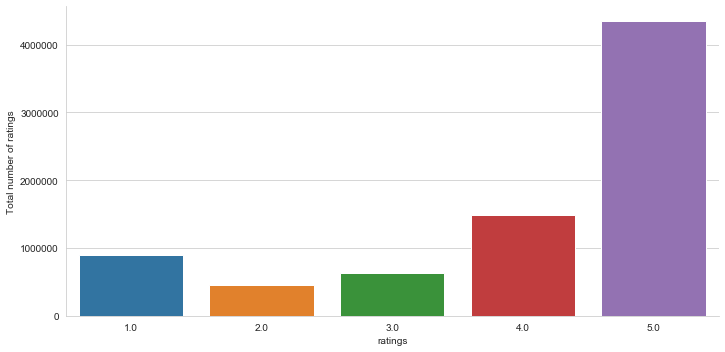

In [9]:
# Check the distribution of ratings

curattr = 'ratings'
g = sns.catplot(curattr, data=mydata, aspect=2.0,kind='count')
g.set_ylabels("Total number of ratings")
sns.despine()
plt.gcf().set_size_inches(10, 5)


Item=[]
for i in mydata[curattr].unique():
    Item.append([
    i,
    len(mydata[mydata[curattr] == i]),
    round((len(mydata[mydata[curattr] == i])/len(mydata[curattr]))*100,2),       
    ]);

curattrdf=pd.DataFrame(data=Item,columns=[curattr,'Count','Mix%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index() 

#### Observation:
1.56% of records have product with rating of 5.
2.19% of records have product with rating of 4.
3.Product with rating of 2 is appearing the least (6%).
4.Data is heavily concentrated around ratings 4 and 5.

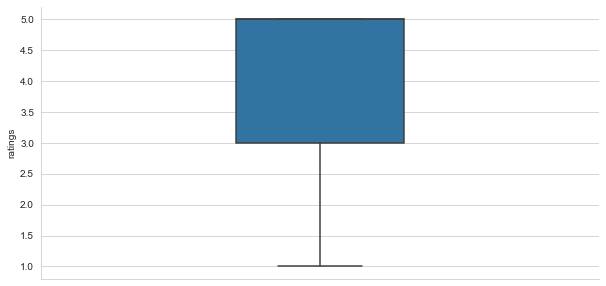

In [10]:
curattr = 'ratings'
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3)
sns.despine()
plt.gcf().set_size_inches(10, 5)

#### Observation:
1.Median is 5 which is the highest rating.
2.There are no outliers.

In [11]:
# create subset of data from the original data set for focussed analysis.
# only items that have atleast 50 reviews and users who have given atleast 50 reviews is considered for recommendater models

min_item_ratings = 50  
filter_item = mydata['product_id'].value_counts() >= min_item_ratings
filter_item = filter_item[filter_item].index.tolist()

min_user_ratings = 50
filter_users = mydata['user_id'].value_counts() >= min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

mydata_filtered = mydata[(mydata['product_id'].isin(filter_item)) & (mydata['user_id'].isin(filter_users))]

print('The original data frame shape:\t{}'.format(mydata.shape))
print('The new data frame shape:\t{}'.format(mydata_filtered.shape))
percentage_coverage = (mydata_filtered.shape[0]/mydata.shape[0])*100
print('Percentage of data considered:\t{:4.2f}%'.format(percentage_coverage))
print('Number of unique items in orginal dataset:\t{}'.format(mydata.product_id.nunique()))
print('Number of unique items for analysis:\t{}'.format(mydata_filtered.product_id.nunique()))
print('Number of unique users in orginal dataset:\t{}'.format(mydata.user_id.nunique()))
print('Number of unique users for analysis:\t{}'.format(mydata_filtered.user_id.nunique()))

The original data frame shape:	(7824482, 3)
The new data frame shape:	(79182, 3)
Percentage of data considered:	1.01%
Number of unique items in orginal dataset:	476002
Number of unique items for analysis:	16993
Number of unique users in orginal dataset:	4201696
Number of unique users for analysis:	1540


In [12]:
# calculation of average ratings for the products using the filtered data set.
# no of users is for representation purpose to indicate the total number of users who reviewed the item in the original data set.

mydata_filtered_temp_1 = mydata.groupby(['product_id']).agg({'user_id': 'count'})
mydata_filtered_temp_1.columns=['no of users']
mydata_filtered_temp_2 = mydata_filtered.groupby(['product_id']).mean()
prodavgscore = mydata_filtered_temp_2.join(mydata_filtered_temp_1)
prodavgscore.ratings = round(prodavgscore.ratings,1)
prodavgscore = prodavgscore.reset_index()
prodavgscore.nlargest(5,'ratings')

,product_id,ratings,no of users
2,1400501520,5.0,82
9,3744295508,5.0,60
10,9573212919,5.0,199
13,9985511476,5.0,62
14,B000001OM4,5.0,98


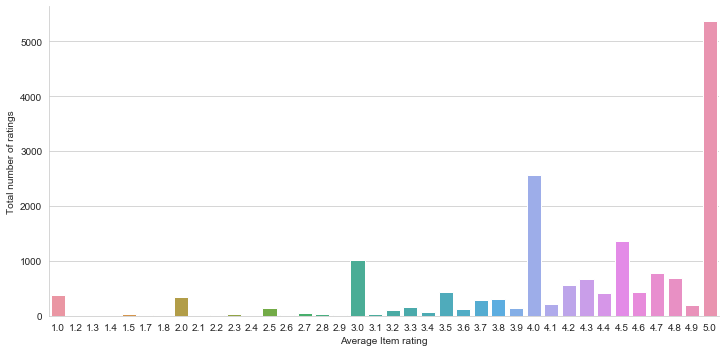

In [13]:
# distribution of average rating of items
curattr = 'ratings'
g = sns.catplot(curattr, data=prodavgscore, aspect=2.0,kind='count')
g.set_ylabels("Total number of ratings")
g.set_xlabels("Average Item rating")
sns.despine()
plt.gcf().set_size_inches(10, 5)

#### Observation:
1.Distribution of average ratings shows concentration of data between 4 to 5.
2 High number of items still carry review rating of 5 even on average basis  (considering the filter criteria used).

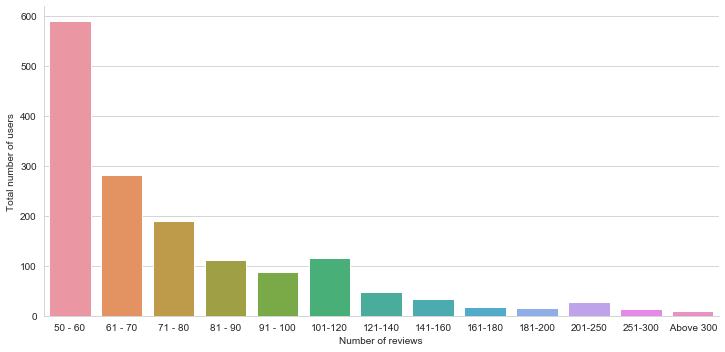

In [14]:
# distribution of user review counts

user_list = mydata_filtered['user_id'].unique()
temp = pd.DataFrame(mydata['user_id'].value_counts(dropna=True, sort=True),copy=True)
temp = temp.reset_index()
temp.columns = ['user_id', 'counts']
user_reviewcount = temp.loc[(temp['user_id'].isin(user_list))]
user_reviewcount.is_copy = False
user_reviewcount['review_count_range'] = pd.cut(x=user_reviewcount['counts'], bins=[49,60,70,80,90,100,120,140,160,180,200,250,300,1000],\
                                                labels=['50 - 60', '61 - 70','71 - 80', '81 - 90','91 - 100','101-120','121-140','141-160','161-180','181-200','201-250','251-300',' Above 300'])

g = sns.catplot('review_count_range', data=user_reviewcount, aspect=2.0,kind='count')
g.set_ylabels("Total number of users")
g.set_xlabels("Number of reviews")
sns.despine()
plt.gcf().set_size_inches(10, 5)

#### Observation:
1.The above graph shows how many users have done how many product reviews .
2 Close to 600 users have done 50-60 item reviews.

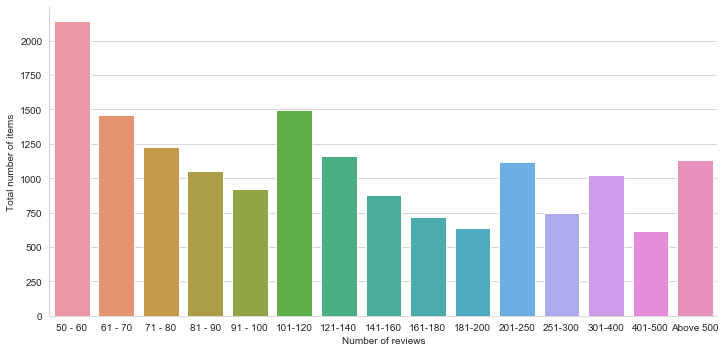

In [15]:
# distribution of item review counts

item_reviewcount = prodavgscore.copy(deep = True)
item_reviewcount['review_count_range'] = pd.cut(x=item_reviewcount['no of users'], bins=[49,60,70,80,90,100,120,140,160,180,200,250,300,400,500,1000],\
                                                labels=['50 - 60', '61 - 70','71 - 80', '81 - 90','91 - 100','101-120','121-140','141-160','161-180','181-200','201-250','251-300','301-400','401-500','Above 500'])

g = sns.catplot('review_count_range', data=item_reviewcount, aspect=2.0,kind='count')
g.set_ylabels("Total number of items")
g.set_xlabels("Number of reviews")
sns.despine()
plt.gcf().set_size_inches(10, 5)

#### Observation:
1.The above graph shows how many items have got how many user reviews .
2.2000+ items have got 50-60 user reviews.

## 4. Model Building and Evaluation

In [16]:
# Setting up common parameters
seed=99
cv=3
k=5 
threshold=4

##### 4.1 Popularity based recommender model

In [17]:
print("Top 10 products based on average ratings")
print()
print(prodavgscore.nlargest(10,'ratings'))
print("\n")
print("Top 10 products based on user review count")
print()
print(prodavgscore.nlargest(10,'no of users'))

Top 10 products based on average ratings

    product_id  ratings  no of users
2   1400501520      5.0           82
9   3744295508      5.0           60
10  9573212919      5.0          199
13  9985511476      5.0           62
14  B000001OM4      5.0           98
16  B000001OMI      5.0           52
18  B00000DM9W      5.0          332
21  B00000J061      5.0          262
24  B00000J1EQ      5.0          138
25  B00000J1F3      5.0           57


Top 10 products based on user review count

       product_id  ratings  no of users
13071  B0074BW614      4.4        18244
16286  B00DR0PDNE      3.8        16454
13711  B007WTAJTO      4.7        14172
4927   B0019EHU8G      4.9        12285
12694  B006GWO5WK      4.2        12226
8484   B003ELYQGG      4.1        11617
8495   B003ES5ZUU      4.9        10276
13588  B007R5YDYA      4.8         9907
12501  B00622AG6S      4.5         9823
1386   B0002L5R78      4.6         9487


In [18]:
# create rating for the items based on sorted list
mydata_product_sort = prodavgscore.sort_values(['ratings', 'product_id'], ascending = [0,1])           
mydata_product_sort['Rank'] = mydata_product_sort['ratings'].rank(ascending=0, method='first')

# recommended items based on Top k selection
recom_product = mydata_product_sort['product_id'].head(k).values.tolist()
print(recom_product)

['1400501520', '3744295508', '9573212919', '9985511476', 'B000001OM4']


In [19]:
# create function to return top k popular items for a given user id

def recommend(user_id,k):

    product_popularity_recommendation =  mydata_product_sort.head(k)
    recom_product = mydata_product_sort.head(k).index.values.tolist()
    user_recommendations = product_popularity_recommendation.copy(deep=True)
    user_recommendations = user_recommendations.reset_index()      
    user_recommendations['user_id'] = user_id                
    cols = user_recommendations.columns.tolist()       
    cols = cols[-1:] + cols[:-1]       
    user_recommendations = user_recommendations[cols]
    return user_recommendations 

In [20]:
# generate ( popularity based ) recommendation for random list of user id selected

user_id_test = mydata_filtered['user_id'].sample(n=5,random_state=seed).values.tolist()
for i in user_id_test:
    print("Validation of results for userId: " +  i)
    print()
    print("Products recommended for the userId: " +  i)
    print(recommend(i,k))
    print("Actual user rating for the recommended item")
    print(mydata[(mydata.product_id.isin(recom_product))  & (mydata.user_id==i)])
    print("Actual top items rated by the userId: " +  i)
    print(mydata[mydata.user_id==i].nlargest(k,'ratings'))
    print("\n")

Validation of results for userId: A1BZIM4WGZ6DZP

Products recommended for the userId: A1BZIM4WGZ6DZP
          user_id  index  product_id  ratings  no of users  Rank
0  A1BZIM4WGZ6DZP      2  1400501520      5.0           82   1.0
1  A1BZIM4WGZ6DZP      9  3744295508      5.0           60   2.0
2  A1BZIM4WGZ6DZP     10  9573212919      5.0          199   3.0
3  A1BZIM4WGZ6DZP     13  9985511476      5.0           62   4.0
4  A1BZIM4WGZ6DZP     14  B000001OM4      5.0           98   5.0
Actual user rating for the recommended item
Empty DataFrame
Columns: [user_id, product_id, ratings]
Index: []
Actual top items rated by the userId: A1BZIM4WGZ6DZP
               user_id  product_id  ratings
155693  A1BZIM4WGZ6DZP  B000067SCY      5.0
255945  A1BZIM4WGZ6DZP  B00008VF8R      5.0
384542  A1BZIM4WGZ6DZP  B0001FTVEA      5.0
459789  A1BZIM4WGZ6DZP  B0002E51CQ      5.0
821693  A1BZIM4WGZ6DZP  B000CSWW92      5.0


Validation of results for userId: AMFXXAOVV4CPJ

Products recommended for the u

#### Observation:
1.The above shows the recommeded items for the given user, actual rating given by the user for the recommended item (if user reviewed it already) and the actual top k items that the user actually reviewed.
2.The above clearly shows that all the users have been recommeded same set of items since the recommendation is based on popularity of the item and not based on user customized.
3.For all the users , top items that they have actually reviewed is not shown as recommendation. This may also be because there are lot of items with 5 rating and hence the top 5 may not match with the user preference. Interestingly, all items that have been recommended are the ones that the users have not reviewed before.

### 4.2 Collaborative Filtering based model

In [21]:
# create rating matrix based on the filtered user product ratings

ratings_matrix = mydata_filtered.pivot(index='user_id', columns='product_id', values='ratings').fillna(0)
user_id = ratings_matrix.index
product_id = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.sample(5)

(1540, 16993)


product_id,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JTI4X3E,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
user_id,,,,,,,,,,,,,,,,,,,,,
AS2II0671KT2C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3BVN2QBNPBHCR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1KI7YHQEOS1RB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2ZR3YTMEEIIZ4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3S5EXYZDEBF3K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
density = (np.count_nonzero(ratings_matrix)/(len(ratings_matrix.index)*len(ratings_matrix.columns)))
density *= 100
print ('Density: {:4.2f}%'.format(density))

Density: 0.30%


#### Observation:
1.The above matrix shows that the sparsity is extremely high.
2.Density of records is only 0.3%.

In [23]:
# for collaborative filtering models setting up the dataset in the format that surprise package requires

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(mydata_filtered[['user_id', 'product_id', 'ratings']], reader)

# splitting the data in to training set and test set using the surprise package

trainset, testset = tts_sur(data, test_size=0.30,random_state=seed)

In [24]:
# running various recommender models on training set, validate on test set and also run cross validation on full dataset for evaluating RMSE 

counter = 0

for model in [SVD(random_state=seed), SVDpp(random_state=seed),\
              KNNBaseline(k=50,verbose=False,sim_options={'name': 'pearson_baseline', 'user_based': True}),\
              KNNBasic(k=50,verbose=False,sim_options={'name': 'cosine', 'user_based': True}),\
              KNNWithMeans(k=50,verbose=False,sim_options={'name': 'cosine', 'user_based': True}),\
              KNNWithZScore(k=50,verbose=False,sim_options={'name': 'cosine', 'user_based': True}),\
              KNNBaseline(k=50,verbose=False,sim_options={'name': 'pearson_baseline', 'user_based': False}),\
              KNNBasic(k=50,verbose=False,sim_options={'name': 'cosine', 'user_based': False}),\
              KNNWithMeans(k=50,verbose=False,sim_options={'name': 'cosine', 'user_based': False}),\
              KNNWithZScore(k=50,verbose=False,sim_options={'name': 'cosine', 'user_based': False}),\
              SlopeOne(),NMF(random_state=seed),CoClustering(random_state=seed)]:

    start_time=time.time()
    mname = model.__class__.__name__
    predictions = model.fit(trainset).test(testset)
    
    #capture predictions in a separate dataframe for calculation of precision and recall
    
    predictions_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est','details'])
    predictions_df.drop('details',axis=1,inplace=True)
    
    #calculate number of relevant records based on actual rating >= threshold value
    
    a = pd.DataFrame(predictions_df[predictions_df.rui >=threshold].groupby(['uid'])['rui'].count())
    a.rename(columns = {'rui':'n_relevant'},inplace=True)
    
    #calculate number of recommended records based on predicted rating >= threshold value
    
    b = pd.DataFrame(predictions_df[predictions_df.est >=threshold].groupby(['uid'])['est'].count())
    b.rename(columns = {'est':'n_recommend'},inplace=True)
    
    #calculate number of recommended records based on predicted rating >= threshold value for a specific number of Top k recommendations
    
    b['n_reco_k']=b.n_recommend.copy(deep=True)
    b['n_reco_k'].clip(upper=k,inplace=True)
    
    #calculate number of relevant and recommended records based on actual and predicted rating >= threshold value
    
    c= pd.DataFrame(predictions_df[(predictions_df.est >=threshold) & (predictions_df.rui >=threshold)].groupby(['uid'])['rui'].count())
    c.rename(columns = {'rui':'n_rel_n_reco'},inplace=True)
    
    #calculate number of relevant and recommended records based on actual and predicted rating >= threshold value for a specific number of Top k recommendations
    
    c['n_rel_n_reco_k']=c.n_rel_n_reco.copy(deep=True)
    c['n_rel_n_reco_k'].clip(upper=k,inplace=True)    
    abc=a.join([b,c])
    
    #calculate evaluation metrices - RMSE
    
    rmse = accuracy.rmse(predictions)
    
    #calculate evaluation metrices - precision and recall -  user id level and then averaged at total level
    
    abc['precision'] = abc.n_rel_n_reco/abc.n_recommend
    abc['recall']=abc.n_rel_n_reco/abc.n_relevant
    precision = abc.precision.mean()
    recall = abc.recall.mean() 
    
    #calculate evaluation metrices - precision and recall @ k top recommendation  -  user id level and then averaged at total level
    
    abc['precision_k'] = abc.n_rel_n_reco_k/abc.n_reco_k
    abc['recall_k']=abc.n_rel_n_reco_k/abc.n_relevant   
    precision_k = abc.precision_k.mean()
    recall_k = abc.recall_k.mean()     
    
    
    
    #calculate rmse based on cross validation on full data
    
    results = cross_validate(model, data, measures=['RMSE'], cv=cv, return_train_measures=False,verbose=False,n_jobs=2)
    rmse_cv = results.get('test_rmse').mean()
    rmse_std = results.get('test_rmse').std()

    if counter == 6: 
        mname= 'KNNBaseline - Item based'
    elif counter == 7: 
        mname= 'KNNBasic - Item based'
    elif counter == 8: 
        mname= 'KNNWithMeans - Item based'
    elif counter == 9: 
        mname= 'KNNWithZScore - Item based'        
    else:
        mname = model.__class__.__name__    
        
    output = {'Model':mname,
              'RMSE':rmse,
              'Precision':precision,
              'Recall':recall,
              'Precision_k':precision_k,
              'Recall_k':recall_k,              
              'RMSE:CV Mean':rmse_cv,
              'RMSE:CV StdDev':rmse_std
               }

    recomodelresult = recomodelresult.append(output,ignore_index=True)
    et=round(time.time()-start_time,2)
    print(mname + '  completed in',et, 'seconds')    
    counter = counter+1

    ;



RMSE: 0.9587
SVD  completed in 20.21 seconds
RMSE: 0.9606
SVDpp  completed in 152.86 seconds
RMSE: 1.0159
KNNBaseline  completed in 11.38 seconds
RMSE: 1.0976
KNNBasic  completed in 11.79 seconds
RMSE: 1.0392
KNNWithMeans  completed in 11.99 seconds
RMSE: 1.0439
KNNWithZScore  completed in 12.06 seconds
RMSE: 1.0043
KNNBaseline - Item based  completed in 81.93 seconds
RMSE: 1.0835
KNNBasic - Item based  completed in 84.58 seconds
RMSE: 1.1089
KNNWithMeans - Item based  completed in 87.14 seconds
RMSE: 1.1205
KNNWithZScore - Item based  completed in 85.82 seconds
RMSE: 1.0830
SlopeOne  completed in 55.04 seconds
RMSE: 1.1390
NMF  completed in 22.74 seconds
RMSE: 1.0574
CoClustering  completed in 15.85 seconds


## 5. Evaluation and Conclusion

In [25]:
recomodelresult.round(2).head(100).sort_values(by='RMSE:CV Mean',ascending=True).style.hide_index()

Model,RMSE,Precision,Recall,Precision_k,Recall_k,RMSE:CV Mean,RMSE:CV StdDev
SVD,0.96,0.87,0.85,0.97,0.45,0.96,0
SVDpp,0.96,0.87,0.83,0.97,0.44,0.96,0
KNNBaseline,1.02,0.87,0.85,0.98,0.46,1.01,0.01
KNNBaseline - Item based,1,0.86,0.86,0.98,0.46,1.01,0
KNNWithMeans,1.04,0.86,0.81,0.96,0.45,1.04,0.01
KNNWithZScore,1.04,0.86,0.81,0.96,0.45,1.05,0
CoClustering,1.06,0.86,0.78,0.96,0.45,1.06,0
KNNBasic - Item based,1.08,0.83,0.88,0.97,0.48,1.09,0.01
SlopeOne,1.08,0.86,0.77,0.95,0.44,1.09,0
KNNBasic,1.1,0.84,0.89,0.98,0.49,1.1,0


#### Observation:
1.The above table shows the RMSE scores of all models.
2.RMSE column is the score based on test data where as RMSE:CV Mean is the cross validation mean score based on full data set.
3.From the above it can be seen that the lowest RMSE is given by SVD model.
4.Item based models score relatively poorly compared to user based model (except KNNBaseline and KNNBasic).
5.Precision measures % of recommended items that are relevant ,on recommended items.
6.Recall measures % of recommended items that are relevant, on relevant items.
7.Precision and Recall values are calculated for threshold of >=4 rating.
8.Precision_k and Recall_k values are calculated for threshold of >=4 rating for top 5 recommendation.
9.SVD scores highest in precision and ranks 4th on recall.
10.Recall_k is lower than recall since recall_k is measured only for 5 recommendations ( Top 5 recommendations k =5).
11.For SVD , 87% of the recommended items are relevant for the users ( Precision), 97% of the top 5 recommended items are relevant for the uses (Precision_k).
12.For KNNBasic item based model, 48% of the relevant items appear on Top 5 recommendation list(Recall_k).

In [26]:
# create recommendation for random list of selected users.
# for this, SVD model is run on data set with selected user and the items that the user has not reviewed yet.
# from the full items list , list of items that the given user has already reviewed is removed and only the balance items are provided for SVD model ( with default rating as 0)

all_items=mydata_filtered.product_id.unique()

def getuserreco(uid,k,c):
    
    # get the list of items not reviewed by the user
    uid_items=mydata_filtered[mydata_filtered.user_id==uid].product_id.unique()
    uid_items_pred = np.setdiff1d(all_items,uid_items,assume_unique=False)
    
    # generate recomset as data set with user and items selected above for the model to run and give the result
    recomset=[[uid,item,0.0] for item in uid_items_pred]
    if c==1:
        reco_model = SVD(random_state=seed)
    elif c==2:
        reco_model = KNNBaseline(k=50,verbose=False,sim_options={'name': 'pearson_baseline', 'user_based': False})
    else:
        pass
           
    # train the model on trainset and run the model on the recomset dataset to get the predictions
    user_pred = reco_model.fit(trainset).test(recomset)
    user_recom_df = pd.DataFrame(user_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
    return user_recom_df.nlargest(k,'est').round(2).drop(['rui','details'],axis=1)


In [27]:
# print top 5 recommendation for randomly selected 5 users

user_id_test = mydata_filtered['user_id'].sample(n=5,random_state=seed).values.tolist()
for i in user_id_test:

    print("Products recommended for the userId: " +  i)
    print()
    print("Recommendation based on SVD model")
    print(getuserreco(i,5,1))
    print()
    print("Recommendation based on Item based model")
    print(getuserreco(i,5,2))    
    print("\n")

Products recommended for the userId: A1BZIM4WGZ6DZP

Recommendation based on SVD model
                uid         iid  est
63   A1BZIM4WGZ6DZP  B00001P4ZH  5.0
97   A1BZIM4WGZ6DZP  B00003CWDG  5.0
219  A1BZIM4WGZ6DZP  B0000511U7  5.0
220  A1BZIM4WGZ6DZP  B00005125T  5.0
284  A1BZIM4WGZ6DZP  B00005LB8P  5.0

Recommendation based on Item based model
                 uid         iid  est
1200  A1BZIM4WGZ6DZP  B0001Y7UAI  5.0
1796  A1BZIM4WGZ6DZP  B00081A2KY  5.0
1852  A1BZIM4WGZ6DZP  B0009GZAGO  5.0
2138  A1BZIM4WGZ6DZP  B000BQ7GW8  5.0
2445  A1BZIM4WGZ6DZP  B000EVSLRO  5.0


Products recommended for the userId: AMFXXAOVV4CPJ

Recommendation based on SVD model
                 uid         iid   est
7453   AMFXXAOVV4CPJ  B002TLTE6Y  5.00
10051  AMFXXAOVV4CPJ  B004ELA0SS  5.00
6126   AMFXXAOVV4CPJ  B001TH7T2U  4.97
6121   AMFXXAOVV4CPJ  B001TH7GUA  4.97
8528   AMFXXAOVV4CPJ  B003FVJYF8  4.97

Recommendation based on Item based model
                uid         iid  est
186   AMFXXAOVV4CPJ 

#### Conclusion:
1.Popularity based recommendation does not consider user attributes and hence recommend a static list of items based on popularity ratings.
2.However collaborative filtering based models provide customized recommendation based on the user.
3.The recommendation based on SVD gives list of items that the user will like based on the rating that the model estimates the user is likely to give.
4.Hence this recommendation is considered customized for the user and the list of items recommended varies based on the user.
5.Interestingly, the list of top 5 recommendation is completely different between SVD and KNN Item based model.